## App Store Reivew analysis - 튜터링
---------------

## 개요

### 문서 목적
- **튜터링**에서 서비스 중인 **튜터링** 앱에 대한 분석 리포트 작성을 위해 문서를 만들었습니다.

### 분석 대상
- **구글 플레이 스토어에 고객이 작성한 리뷰 정보**
  - user_name : 이용자 이름(닉네임)
  - user_app_rating : 별점(1~5)
  - user_review_date : 리뷰 작성 날짜
  - company_comment_date : 답변 작성 날짜
  - user_simple_comment : 리뷰 내용
  - user_specific_comment : 리뷰 상세 내용
    - user_simple_comment의 내용이 길 경우 웹 상에서 다 보이지 않고 상세하게 볼 수 있도록 구성되어 있어 추가한 항목입니다. 전처리를 통해 처리 될 예정입니다.
  - company_answer_check : 답변 여부


### 분석 일시
- 크롤링 데이터 구성 시간 : 2019년 09월 05일
- 데이터 분석 시작 : 2019년 09월 05일
- 데이터는 2018-12-08 부터 2019-09-04까지 기록으로 구성되어 있습니다.

### 분석 방법
1. 데이터 확인
  - 데이터 전처리
  - 컬럼 확인
2. 시간 기록에 따른 데이터 분석
  - 시간에 따른 별점 변화(별점은 1 ~ 5의 값을 가진다)
  - 요일에 따른 리뷰 분석
  - 답변 시간차(고객 응대 소요 시간)
3. 리뷰 내용에 대한 자연어 분석
  - 리뷰 내용을 Topic modeling로 구성하고 시각화
  - 별점에 따라 주요 키워드 분석 진행

### 분석 환경, 분석자
- 분석 환경
  - language
      - python3
  - library
      - [khaiii](https://github.com/kakao/khaiii) : 카카오에서 제공하는 형태소 분석기
      - [gensim](https://radimrehurek.com/gensim/) : 자연어 처리 방법 중 LDA - Topic Modeling 사용
      - 시각화, 데이터 분석을 위한 Python library

- 분석자
  - github : https://github.com/timetobye


### 안내 사항
- **분석에 사용 될 리뷰 정보는 직접 크롤링**을 하여 데이터 셋을 구성하였습니다.
- 2018년 10월 한국 시장 기준으로 Android(72.2%) vs IOS(27.8%)의 점유율을 갖고 있어서 구글 플레이 스토어를 선택하였습니다.
  - [참고 링크 - Difference in Mobile OS Market Share is notable in US, Japan and South Korea](https://en.appa.pe/whitepaper/2018/)
  
--------------------------------------------

### 분석 결과

- 총평 : 여느 앱과 마찬가지로 좋은 점과 해결해야 할 것들이 산적해 있습니다.
- 결과는 PDF로 정리되었습니다. 업로드는 미정
----------------

### code

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.style as style
import seaborn as sns
import khaiii
import missingno as msno
import warnings
import re
import calendar
import gensim
import os
from collections import Counter
from datetime import datetime
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from pyLDAvis import gensim as gensimvis
from pyLDAvis import display
from pyLDAvis import save_html as lda_visualization
from khaiii import KhaiiiApi
from matplotlib import font_manager, rc
apple = font_manager.FontProperties(fname = '/Library/Fonts/AppleGothic.ttf').get_name()
rc('font', family = apple)

warnings.filterwarnings('ignore')
style.use('fivethirtyeight')
%matplotlib inline

## 1. 데이터 확인

### 데이터 전처리 - Preprocessing

In [2]:
# read_csv to make dataframe

google_playstore_user_review_orginal_df = pd.read_csv('review_data/tutoring_app_user_reviews_2019-09-05.csv')
google_playstore_user_review_orginal_df.head(10)

,user_name,user_app_rating,user_review_date,company_comment_date,user_simple_comment,user_specific_comment,company_answer_check
0,무밍,3,2019년 8월 6일,2019년 8월 8일,다른 앱들보다 저렴해서 좋아요. 대부분의 튜터분들도 친절하셔서 좋구요. 저는 지금 ...,다른 앱들보다 저렴해서 좋아요. 대부분의 튜터분들도 친절하셔서 좋구요. 저는 지금 ...,answer
1,자듀,5,2019년 8월 8일,2019년 8월 8일,지금까지 다른 전화영어도 해보았지만 이렇게 신박한 영어앱은 처음입니다.. 시간에 치...,no_specific_comment,answer
2,조미호,5,2019년 7월 6일,no_answer,중국에 어학연수 가기 전에 튜터링으로 공부하고 가려고 수강권 결제했습니다. 튜터가 ...,no_specific_comment,no_answer
3,레이첼,5,2019년 7월 26일,no_answer,안녕하세요 튜터링을 거의 3년째 이용하고있는 회원입니다. 영어회화를 위해 이 앱을 ...,no_specific_comment,no_answer
4,hyesun KIM,1,2019년 9월 4일,no_answer,앱이 실행이 안되는데요???????? 수강권 어ㅉㅓ죠?????,no_specific_comment,no_answer
5,최강민,5,2019년 9월 4일,no_answer,영어 초보에게도 고수에게도 추천하는 앱입니다. 친절하시고 활발하신 선생님들과 1:1...,no_specific_comment,no_answer
6,인간성우,1,2019년 9월 4일,no_answer,수강권 넘 비쌈...,no_specific_comment,no_answer
7,오늘은귤이좋겠어,5,2019년 9월 4일,no_answer,맨날 묵언수행으로 영어를 해서 그런지 아는 만큼 영어를 말로 할 수 없었는데 튜터링...,맨날 묵언수행으로 영어를 해서 그런지 아는 만큼 영어를 말로 할 수 없었는데 튜터링...,no_answer
8,kim hong seok,5,2019년 9월 4일,no_answer,앱 실행☞나의 코스☞괴목 선택 후에 선택 가능 한 튜터 분들 표시 리스트에서 튜터 ...,no_specific_comment,no_answer
9,구지영,2,2019년 9월 4일,no_answer,왜가입이안되죠 인증번호에서 계속막히네요 어떻게좀 도와주세요,no_specific_comment,no_answer


In [3]:
# check dataframe info

google_playstore_user_review_orginal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 7 columns):
user_name                884 non-null object
user_app_rating          884 non-null int64
user_review_date         884 non-null object
company_comment_date     884 non-null object
user_simple_comment      884 non-null object
user_specific_comment    884 non-null object
company_answer_check     884 non-null object
dtypes: int64(1), object(6)
memory usage: 48.4+ KB


### check-point

- 크롤링 과정에서도 첫 3개가 시간 순서 정렬과 관계없이 항상 고정된 값으로 구성되어 있었다.
  - 해당 부분에 대해서는 날짜 기준으로 정렬할 것
- 중복 값이 있는 경우를 방지하기 위해 중복 체크도 진행한다.
- 날짜 정보도 사용하기 쉽게 YYYY-MM-DD 형식으로 처리 할 것
- 요일 정보를 얻기 위해 작업을 진행 할 것
- user의 comment를 정리하기 위해 user_comment 컬럼을 추가하고 아래와 같이 진행
  - user_specific_comment가 있을 경우 user_comment로 처리
  - user_specific_comment가 없을 경우 user_simple_comment가 user_comment로 처리


In [4]:
def sort_dataframe(df):
    sorted_df = df.sort_values(by='user_review_date', ascending=False).reset_index(drop=True)
    
    return sorted_df

def drop_duplicate_dataframe(df):
    drop_dp_df = df.drop_duplicates()
    drop_dp_df.reset_index(drop=True, inplace=True)
    
    return drop_dp_df

def get_weekday(date):
    if date == 'no_answer':
        return date
    
    weekday_info_dict = {
        0 : 'Mon',
        1 : 'Tue',
        2 : 'Wed',
        3 : 'Thu',
        4 : 'Fri',
        5 : 'Sat',
        6 : 'Sun'
    }
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)
    
    year, month, day = [int(value) for value in get_regex_date]
    
    weekday_number = calendar.weekday(year, month, day)
    weekday_value = weekday_info_dict[weekday_number]
    
    return weekday_value

def convert_date_format(date):
    if date == 'no_answer':
        return date
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)

    if len(get_regex_date[1]) == 1:
        get_regex_date[1] = '0' + get_regex_date[1]
        
    if len(get_regex_date[2]) == 1:
        get_regex_date[2] = '0' + get_regex_date[2]
    
    join_string = '-'
    convert_date = join_string.join(get_regex_date)
    
    return convert_date

def arrange_user_comment(df):
    user_comment = []
    
    for index, row in df.iterrows():    
        if row['user_specific_comment'] == 'no_specific_comment':
            user_comment.append(row['user_simple_comment'])
        else:
            user_comment.append(row['user_specific_comment'])

    df['user_comment'] = user_comment
    df.drop(['user_simple_comment', 'user_specific_comment'], axis=1, inplace=True)
    df = df[['user_name', 'user_app_rating', 'user_review_date', 'company_comment_date', 'user_review_weekday', 'user_comment', 'company_answer_check']]
    
    return df

def user_data_preprocessing(google_playstore_user_review_orginal_df):
    # sort user_review_date
    sorted_user_review_df = sort_dataframe(google_playstore_user_review_orginal_df)

    # drop duplicate
    drop_dp_user_review_df = drop_duplicate_dataframe(sorted_user_review_df)

    # get weekday from user_review_date
    drop_dp_user_review_df['user_review_weekday'] = drop_dp_user_review_df['user_review_date'].apply(get_weekday)

    # convert_date_format for applying function in pandas
    drop_dp_user_review_df['user_review_date'] = drop_dp_user_review_df['user_review_date'].apply(convert_date_format)
    drop_dp_user_review_df['company_comment_date'] = drop_dp_user_review_df['company_comment_date'].apply(convert_date_format)

    # arrange_user_comment
    arranged_user_review_df = arrange_user_comment(drop_dp_user_review_df)
    
    return arranged_user_review_df

In [5]:
arranged_user_review_df = user_data_preprocessing(google_playstore_user_review_orginal_df)
arranged_user_review_df.head()

,user_name,user_app_rating,user_review_date,company_comment_date,user_review_weekday,user_comment,company_answer_check
0,hyesun KIM,1,2019-09-04,no_answer,Wed,앱이 실행이 안되는데요???????? 수강권 어ㅉㅓ죠?????,no_answer
1,최강민,5,2019-09-04,no_answer,Wed,영어 초보에게도 고수에게도 추천하는 앱입니다. 친절하시고 활발하신 선생님들과 1:1...,no_answer
2,인간성우,1,2019-09-04,no_answer,Wed,수강권 넘 비쌈...,no_answer
3,오늘은귤이좋겠어,5,2019-09-04,no_answer,Wed,맨날 묵언수행으로 영어를 해서 그런지 아는 만큼 영어를 말로 할 수 없었는데 튜터링...,no_answer
4,kim hong seok,5,2019-09-04,no_answer,Wed,앱 실행☞나의 코스☞괴목 선택 후에 선택 가능 한 튜터 분들 표시 리스트에서 튜터 ...,no_answer


--------------------------------

## Basic EDA

### check data info & missingvalue

In [6]:
arranged_user_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 7 columns):
user_name               880 non-null object
user_app_rating         880 non-null int64
user_review_date        880 non-null object
company_comment_date    880 non-null object
user_review_weekday     880 non-null object
user_comment            880 non-null object
company_answer_check    880 non-null object
dtypes: int64(1), object(6)
memory usage: 48.2+ KB


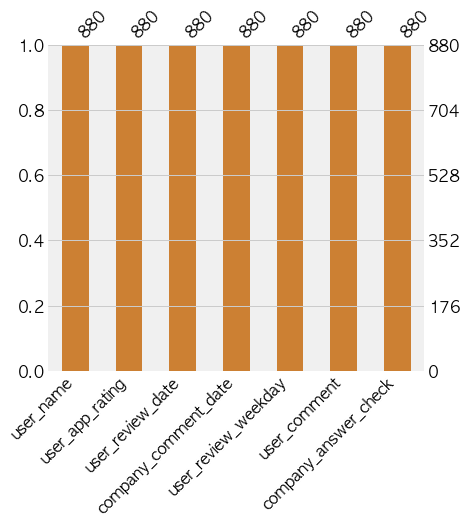

In [7]:
#msno.bar

msno.bar(df=arranged_user_review_df.iloc[:, :], figsize=(6, 6), color=(0.8, 0.5, 0.2))
plt.show()

### 수집된 데이터의 기간

In [8]:
max_date = arranged_user_review_df['user_review_date'].max()
min_date = arranged_user_review_df['user_review_date'].min()

print(f'수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 {min_date} 부터 {max_date} 까지 입니다.')

수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 2018-12-08 부터 2019-09-04 까지 입니다.


### 리뷰를 작성한 사람들은 누구일까요?

In [9]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('user').reset_index(name='writing_count')
    sorted_df_count = df_count.sort_values('writing_count', ascending=False)
    arranged_df = sorted_df_count.reset_index(drop=True)

    return arranged_df

In [10]:
arrange_count_df = arrange_count_value(arranged_user_review_df, 'user_name')
arrange_count_df.head(10)

,user,writing_count
0,Google 사용자,101
1,ᄋᄋ,3
2,이선영,2
3,이지현,2
4,이수민,2
5,Hyehyeon Jang,1
6,김윤미,1
7,남나희,1
8,김단아,1
9,유지혜,1


- **Google 사용자**가 다수가 나온 이유를 살펴보니, 앱스토어에서 실제로 리뷰 작성자의 이름이 Google 사용자라고 되어 있다.
  - 탈퇴를 했거나, 혹은 익명의 아이디를 처리하는 방식으로 판단된다.
  - 결론적으로 Google 사용자를 잠시 제외하고 살펴보겠다.

In [11]:
drop_arrange_count_df = arrange_count_df.drop(index=0).reset_index(drop=True)

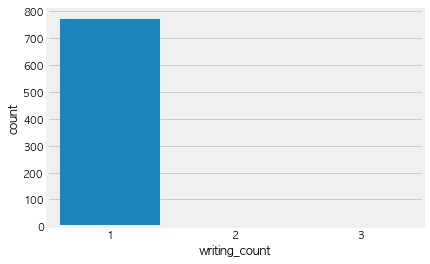

In [12]:
# 이용자들은 개인당 몇 번이나 리뷰를 달았을까?

sns.countplot(x='writing_count', data = drop_arrange_count_df)

In [13]:
groupby_user_review_count = drop_arrange_count_df.groupby('writing_count', as_index=False).count()
groupby_user_review_count.rename(columns = {'user' : 'count'}, inplace=True)
groupby_user_review_count['ratio'] = round(groupby_user_review_count['count']/sum(groupby_user_review_count['count']), 2)
groupby_user_review_count

,writing_count,count,ratio
0,1,770,0.99
1,2,3,0.00
2,3,1,0.00


- 96%이상의 이용자가 1번 정도의 리뷰를 달았고, 소수의 이용자가 2~3번 리뷰를 달은 것으로 파악된다.

### 어떤 요일에 많이 달았을까?

In [14]:
weekday_count = arrange_count_value(arranged_user_review_df, 'user_review_weekday')
weekday_count.rename(columns={'user' : 'weekday'}, inplace=True)

In [15]:
weekday_count

,weekday,writing_count
0,Tue,182
1,Wed,135
2,Thu,134
3,Fri,115
4,Sat,113
5,Mon,113
6,Sun,88


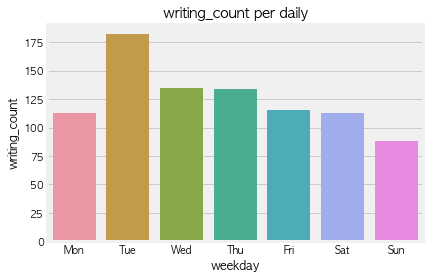

In [16]:
# draw weekday graph

weekday_order_list = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sns.barplot(x='weekday', y='writing_count', data=weekday_count, order=weekday_order_list)
plt.title('writing_count per daily')
plt.show()

- **화요일**이 가장 높은 리뷰 작성일, **일요일**이 가장 적은 리뷰 작성일인 것을 보여주고 있다.
- 일요일에는 공부를 쉬어서 그런걸려나?

### 별점 분포는 어떻게 되어 있을까?

In [17]:
app_rating_count = arrange_count_value(arranged_user_review_df, 'user_app_rating')
app_rating_count.rename(columns={'user' : 'app_rating', 'writing_count' : 'rating_count'}, inplace=True)
app_rating_count

,app_rating,rating_count
0,5,515
1,1,150
2,4,90
3,3,90
4,2,35


In [77]:
app_rating_count['ratio'] = round(app_rating_count['rating_count']/sum(app_rating_count['rating_count']), 2)
app_rating_count.sort_values(by='app_rating', ascending=False, inplace=True)
app_rating_count

,app_rating,rating_count,ratio
0,5,515,0.59
2,4,90,0.10
3,3,90,0.10
4,2,35,0.04
1,1,150,0.17


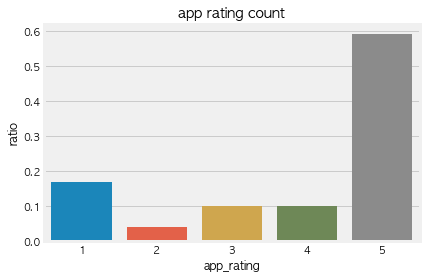

In [19]:
# draw app_rating graph

app_rating_order_list = [1, 2, 3, 4, 5]
sns.barplot(x='app_rating', y='ratio', data=app_rating_count, order=app_rating_order_list)
plt.title('app rating count')
plt.show()

- 5점 59%, 4점 4%, 3점 10%, 2점 10%, 1점 17% 을 이용자들은 리뷰로 남겼다.
- 1점이 많다는 건 뭔가 문제가 있다는 것 의미한다.

-----------------------

## 2. 시간 기록에 따른 데이터 분석

### 시간에 따른 별점 변화

- 여러가지 접근 방법이 있겠지만, 일별 평균 별점 값을 그래프로 그려서 확인해본다.
- 2019년 09월 04일 기준, 튜터링의 구글 플레이 스토어 별점은 4.1점이다.
- 그래프를 그렸으나 그래프에 표현되는 값이 너무 많은 관계로 2019년 값만 그리도록 하겠습니다.
  - 2019-01-01 부터 2019-09-04
 일 입니다.

In [20]:
app_rating_with_date = arranged_user_review_df[['user_app_rating', 'user_review_date']]
average_app_rating_per_daily = app_rating_with_date.groupby('user_review_date', as_index=False).mean()
average_app_rating_per_daily = average_app_rating_per_daily[average_app_rating_per_daily['user_review_date']>='2019-01-01']
app_rating_with_date.head()

,user_app_rating,user_review_date
0,1,2019-09-04
1,5,2019-09-04
2,1,2019-09-04
3,5,2019-09-04
4,5,2019-09-04


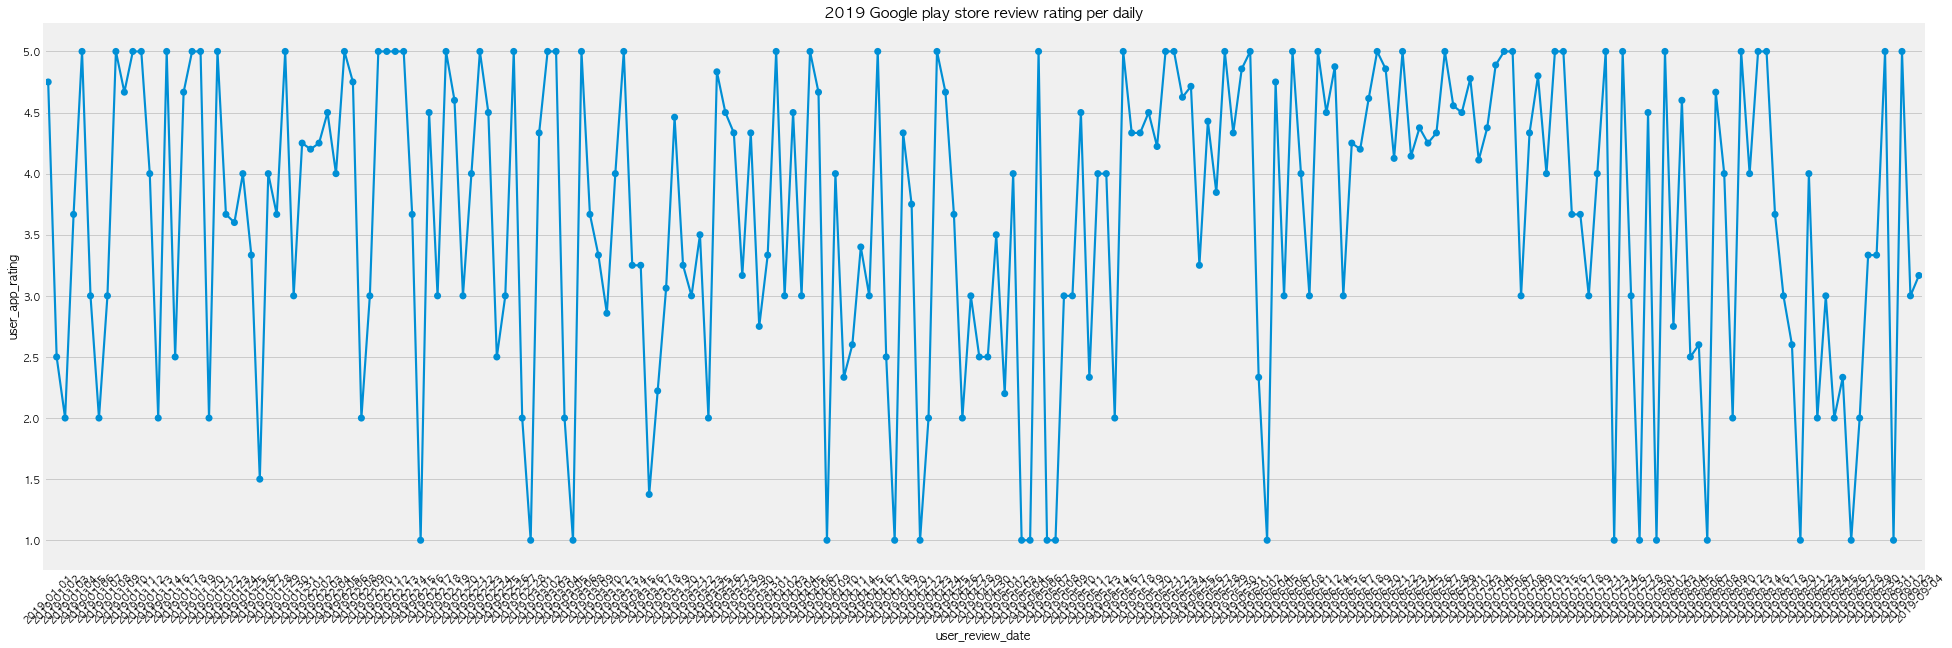

In [21]:
# draw graph : 2019 Google play store review rating per daily

plt.figure(figsize = (30, 10))
sns.pointplot(x='user_review_date', y='user_app_rating', data=average_app_rating_per_daily, scale=0.3)
plt.xticks(rotation=45)
plt.title('2019 Google play store review rating per daily', fontsize = 15)
plt.show()

In [22]:
# check statics

app_rating_with_date.describe()

,user_app_rating
count,880.000000
mean,3.892045
std,1.540040
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


- 앱의 평점이 들쭉날쭉하고 있으며 주기적으로 일평균 1점을 찍는 날도 빈번하다.
- 월별 추세를 살펴보면서 좀 더 살펴봐야겠다.

### 월별 분석
- 월별 분석을 위해 간단한 전처리 진행 후 분석한다.
  - 단, 월별 분석 과정에서 한 달을 완전히 보존하기 위해 2019년 01월 01일 부터 2019년 08월 31일까지로 한정한다.

In [23]:
app_rating_with_monthly = arranged_user_review_df[['user_app_rating', 'user_review_date']]
app_rating_with_monthly.head()

,user_app_rating,user_review_date
0,1,2019-09-04
1,5,2019-09-04
2,1,2019-09-04
3,5,2019-09-04
4,5,2019-09-04


In [24]:
def extract_year_month(date):
    year_month = date[0:7]
    
    return year_month

In [25]:
app_rating_with_monthly['year_month'] = app_rating_with_monthly['user_review_date'].apply(extract_year_month)
app_rating_with_monthly.head()

,user_app_rating,user_review_date,year_month
0,1,2019-09-04,2019-09
1,5,2019-09-04,2019-09
2,1,2019-09-04,2019-09
3,5,2019-09-04,2019-09
4,5,2019-09-04,2019-09


In [57]:
app_rating_with_year_month = app_rating_with_monthly[(app_rating_with_monthly['year_month']>='2019-01')&(app_rating_with_monthly['year_month']<='2019-08')]
app_rating_with_year_month.sort_values('user_review_date', ascending=False, inplace=True)
app_rating_with_year_month.reset_index(drop=True, inplace=True)

In [58]:
app_rating_with_year_month.head()

,user_app_rating,user_review_date,year_month
0,5,2019-08-31,2019-08
1,5,2019-08-30,2019-08
2,1,2019-08-30,2019-08
3,4,2019-08-30,2019-08
4,5,2019-08-29,2019-08


In [59]:
monthly_result = app_rating_with_year_month.groupby('year_month', as_index=False).mean()
monthly_result

,year_month,user_app_rating
0,2019-01,3.747126
1,2019-02,3.974026
2,2019-03,3.304348
3,2019-04,3.343284
4,2019-05,3.952381
5,2019-06,4.361702
6,2019-07,4.406593
7,2019-08,3.101449


In [60]:
monthly_result.describe()

,user_app_rating
count,8.000000
mean,3.773864
std,0.489392
min,3.101449
25%,3.333550
50%,3.849754
75%,4.070945
max,4.406593


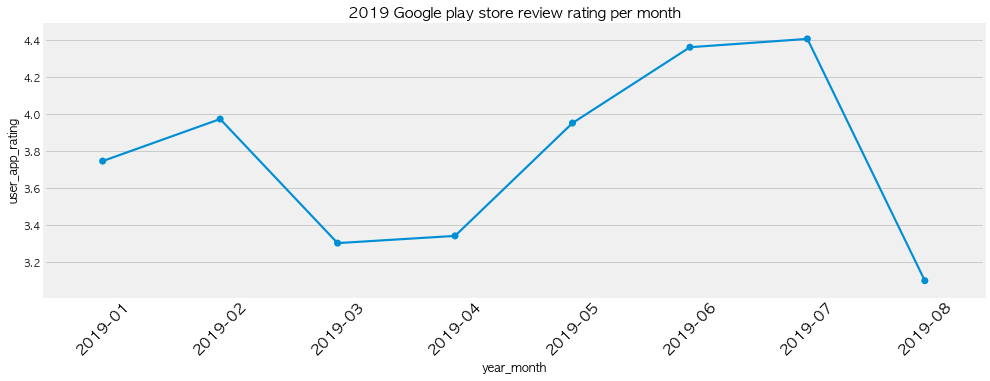

In [61]:
# draw graph : 2019 Google play store review rating per month

plt.figure(figsize = (15, 5))
sns.pointplot(x='year_month', y='user_app_rating', data=monthly_result, scale=0.3)
plt.xticks(rotation=45, fontsize = 15)
plt.title('2019 Google play store review rating per month', fontsize = 15)
plt.show()

- 2019년에는 3점대 초반부터 4점대 중반까지 점수 변동이 크다.
- 2019년 8월에 무슨 일이 있었는지 모르겠으나, 분명 전달에 비해 가장 큰 낙폭이 있는 이유가 있으리라 짐작한다.
- 이 추세로 가면 전체 누적 평점 4점대는 무너질 가능성이 높다.

## 요일에 따른 리뷰 분석

In [62]:
weekday_user_review_df = arranged_user_review_df[['user_app_rating', 'user_review_weekday']]
weekday_user_review_df.head()

,user_app_rating,user_review_weekday
0,1,Wed
1,5,Wed
2,1,Wed
3,5,Wed
4,5,Wed


In [63]:
# crosstab for checking two catagory

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], margins=True).style.background_gradient(cmap='summer_r')
crosstab_result

user_review_weekday,Fri,Mon,Sat,Sun,Thu,Tue,Wed,All
user_app_rating,,,,,,,,
1,10,24,15,27,23,35,16,150
2,4,5,4,6,3,9,4,35
3,13,17,19,8,16,12,5,90
4,17,8,11,11,14,16,13,90
5,71,59,64,36,78,110,97,515
All,115,113,113,88,134,182,135,880


In [64]:
# crosstab with ratio

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
crosstab_result

user_app_rating,1,2,3,4,5
user_review_weekday,,,,,
Fri,0.011364,0.004545,0.014773,0.019318,0.080682
Mon,0.027273,0.005682,0.019318,0.009091,0.067045
Sat,0.017045,0.004545,0.021591,0.012500,0.072727
Sun,0.030682,0.006818,0.009091,0.012500,0.040909
Thu,0.026136,0.003409,0.018182,0.015909,0.088636
Tue,0.039773,0.010227,0.013636,0.018182,0.125000
Wed,0.018182,0.004545,0.005682,0.014773,0.110227


In [65]:
def draw_heatmap(weekday_user_review_df, weekday_order_list):
    crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
    crosstab_result = crosstab_result.reindex(index=weekday_order_list)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(crosstab_result, cmap="YlGnBu", annot=True, cbar=True, fmt='0.3g')
    plt.title('user_app_rating per weekday')
    plt.show()

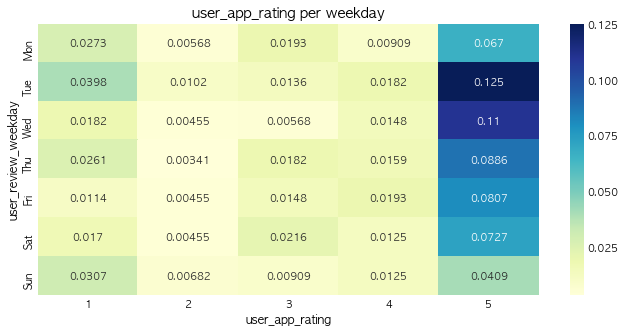

In [66]:
draw_heatmap(weekday_user_review_df, weekday_order_list)

- 화요일에 좋은 점수가 몰려 있음
- 화요일에 좋지 않은 점수도 꽤 있음
- 화요일 수요일에 어떤 일이 일어났는지 심층적으로 분석 해볼 필요가?

---------------------------------

### 고객 응대 소요 시간
- 이용자들에게 답변하는 날짜는 이용자가 리뷰를 달은 날짜와 얼마나 차이가 날까?
  - 답변을 달지 않은 날은 제외하고 파악해보도록 하자
  - 아쉽게도 시, 분, 초는 플레이스토어에서 구할 수가 없어서 day 기준으로 판단한다.
- 리플을 굳이 달지 않아도 되는 항목이 있을 수도 있으니, 리플을 달은 것 vs 달지 않은 것에 대한 비교는 하지 않는다.
- 왠지 느낌적으로 답변도 참 달으셨을 것 같다.

In [67]:
reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_answer = reply_date_df[reply_date_df['company_comment_date']!='no_answer'].reset_index(drop=True)
reply_date_df_with_answer.head()

,user_app_rating,user_review_date,company_comment_date
0,5,2019-09-03,2019-09-04
1,1,2019-09-03,2019-09-04
2,5,2019-09-02,2019-09-02
3,5,2019-09-02,2019-09-03
4,5,2019-09-02,2019-09-02


In [68]:
def convert_string_to_datetime_format(date):
    convert_date = datetime.strptime(date, "%Y-%m-%d")
    
    return convert_date


def calculate_time_deleta(df, column_name_1, column_name2):
    time_delta_list = []
    for index, row in df.iterrows():
        time_delta_value = row[column_name2] - row[column_name_1]
        time_delta_day = time_delta_value.days
        
        time_delta_list.append(time_delta_day)
        
    df['reply_time'] = time_delta_list
    
    return df

In [69]:
# convert string to datetime_format

reply_date_df_with_answer_columns = ['user_review_date', 'company_comment_date']

for column in reply_date_df_with_answer_columns:
    reply_date_df_with_answer[column] = reply_date_df_with_answer[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_answer, 'user_review_date', 'company_comment_date')
cal_reply_time_delta_df.head()

,user_app_rating,user_review_date,company_comment_date,reply_time
0,5,2019-09-03,2019-09-04,1
1,1,2019-09-03,2019-09-04,1
2,5,2019-09-02,2019-09-02,0
3,5,2019-09-02,2019-09-03,1
4,5,2019-09-02,2019-09-02,0


In [70]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('reply_time').reset_index(name='count')
    sorted_df_count = df_count.sort_values('reply_time', ascending=True)
    arranged_df = sorted_df_count.reset_index(drop=True)
    arranged_df = sorted_df_count[sorted_df_count['reply_time']>=0].reset_index(drop=True)
    
    return arranged_df

In [71]:
# 답변 시간이 음수가 되는 경우가 종종 있다. 
# 시스템 문제로 파악 되었으나, 그게 아니고 하나의 글에 리플을 여러번 달 경우 처음 답변과의 시차가 발생해서 나타난 결과이다.
# 이번 분석에서는 음수가 되는 경우는 제외하고 시각화 하겠다.

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df

,reply_time,count,ratio,cumsum_ratio
0,0,121,0.167358,0.167358
1,1,189,0.261411,0.428769
2,2,98,0.135546,0.564315
3,3,82,0.113416,0.677732
4,4,37,0.051176,0.728907
5,5,37,0.051176,0.780083
6,6,28,0.038728,0.818811
7,7,22,0.030429,0.849239
8,8,30,0.041494,0.890733
9,9,10,0.013831,0.904564


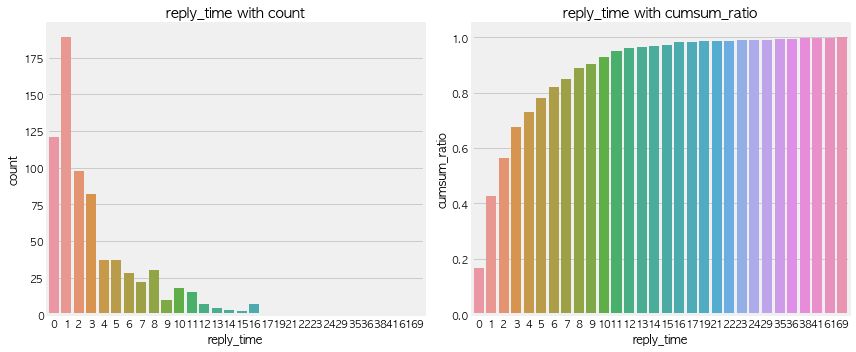

In [72]:
# draw reply_time graph
def draw_count_and_ratio_graph(df):
    y_position = 1.02
    f, ax = plt.subplots(1,2, figsize=(12, 5))

    sns.barplot(x='reply_time', y='count', data=df, ax=ax[0])
    ax[0].set_title(f'reply_time with count')

    sns.barplot(x='reply_time', y='cumsum_ratio', data=df, ax=ax[1])
    ax[1].set_title(f'reply_time with cumsum_ratio')
    
    plt.tight_layout()
    plt.show()

draw_count_and_ratio_graph(reply_time_df)

- 6일정도가 지나야 답변 달성율 80%를 기록한다. 
- 다른 기업들을 살펴보면, 약 2배 가까이 느린 속도로 보인다.(답변이 빠른 기업들은 2~3일안에 80% 기록 중, ex 오늘의집, 지그재그 등)

In [73]:
# filter data set

reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_low_rating = reply_date_df[(reply_date_df['company_comment_date']!='no_answer')&(reply_date_df['user_app_rating']<=2)].reset_index(drop=True)
reply_date_df_with_low_rating.head()


# convert string to datetime_format

reply_date_df_with_low_rating_columns = list(reply_date_df_with_low_rating.columns)

for column in reply_date_df_with_low_rating_columns:
    if column == "user_app_rating":
        continue

    reply_date_df_with_low_rating[column] = reply_date_df_with_low_rating[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_low_rating, 'user_review_date', 'company_comment_date')


# calculate ratio

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df

,reply_time,count,ratio,cumsum_ratio
0,0,35,0.196629,0.196629
1,1,66,0.370787,0.567416
2,2,23,0.129213,0.696629
3,3,7,0.039326,0.735955
4,4,7,0.039326,0.775281
5,5,7,0.039326,0.814607
6,6,4,0.022472,0.837079
7,7,3,0.016854,0.853933
8,8,2,0.011236,0.865169
9,9,3,0.016854,0.882022


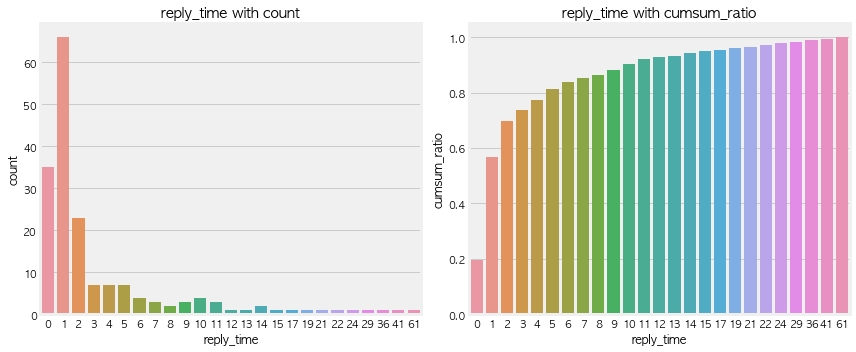

In [74]:
draw_count_and_ratio_graph(reply_time_df)

- 별점이 1~2점인 경우에 하루 정도 빠르게 답변 80%를 달성한다.
------------------------

### 3. 리뷰 내용에 대한 자연어 간단 분석
- KAKAO KHAiii를 이용하여 명사 추출
- 추출된 자료를 바탕으로 Topic modeling로 구성하고 시각화
- 별점에 따라 주요 키워드 분석 진행

In [45]:
def extract_noun(word_object_list):
    extracted_word_noun_list = []
    
    for i, word_object in enumerate(word_object_list):
        word_object_morphs = word_object.morphs
        
        for word in word_object_morphs:
            if word.tag in ['NNG', 'NNP']:
                extracted_word_noun_list.append(word.lex)
    
    return extracted_word_noun_list


def execute_khaiii(user_comment_list):
    sentence_analyze_components = []
    kha_api = KhaiiiApi()
    
    for i, user_comment in enumerate(user_comment_list):
        word_object_list = []
        user_comment_analyze_objects = kha_api.analyze(user_comment)
        
        for user_comment_analyze_object in user_comment_analyze_objects:
            word_object_list.append(user_comment_analyze_object)
            
        extracted_noun_list = extract_noun(word_object_list)  
        sentence_analyze_components.append(extracted_noun_list)
        
#         if i == 1:
#             break
    
    return sentence_analyze_components

In [46]:
# get user_comment_noun_list of all rating reviews

user_comment_list = arranged_user_review_df['user_comment'].tolist()
all_rating_extracted_user_comment_noun_list = execute_khaiii(user_comment_list)

In [47]:
all_rating_extracted_user_comment_noun_list[0][0:10]

['앱', '실행', '수강', 'ㅉ']

In [48]:
def delete_stopwords(word):
    regex = '[ㄱ-ㅎㅏ-ㅣ]+'
    changed_word = re.sub(pattern=regex, repl='None', string=word)
    
    return changed_word

def get_dataframe_from_noun_list(extracted_user_comment_noun_list):
    word_count_dict = {}
    
    for i, word_list in enumerate(extracted_user_comment_noun_list):
        for word in word_list:
            if word not in word_count_dict:
                word_count_dict[word] = 1
            else:
                word_count_dict[word] += 1
                
    word_count_df = pd.DataFrame.from_dict(word_count_dict, orient='index').reset_index().rename(columns = {'index': 'word', 0 : 'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
    word_count_df['word'] = word_count_df['word'].apply(delete_stopwords)
    word_count_df_new = word_count_df[word_count_df['word']!='None']
    
    return word_count_df_new

def draw_graph(word_count_df_new):
    plt.figure(figsize = (15, 5))
    sns.barplot(x = 'word', y = 'count', data=word_count_df_new[0:15])
    plt.title('high frequency Top 15 words', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.show()

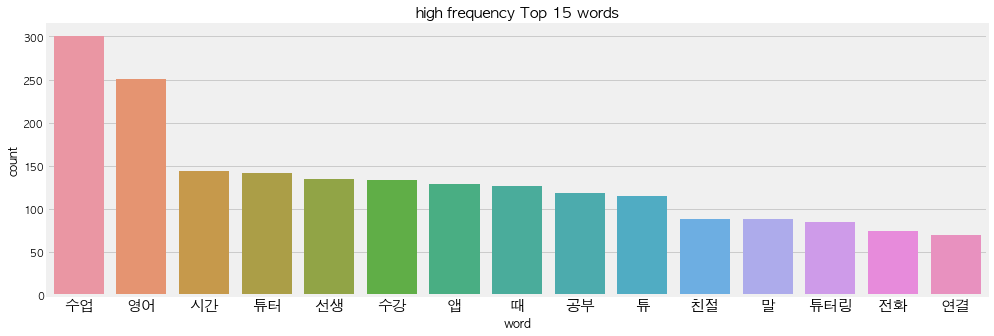

In [49]:
all_rating_word_count_df_new = get_dataframe_from_noun_list(all_rating_extracted_user_comment_noun_list)
draw_graph(all_rating_word_count_df_new)

In [50]:
# Topic Modeling with gensim

def save_model_data(name, folder_name='lda_model'):
    folder_path = f'{os.getcwd()}{"/"}{folder_name}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, name)

    return file_path


def load_model_data(name, folder_name='lda_model'):
    folder_path = f'{os.getcwd()}{"/"}{folder_name}'
    file_path = os.path.join(folder_path, name)

    return file_path


class ReviewModeling:

    def __init__(self, topic_num=10, rating_type='all_rating'):
        self.topic_num = topic_num
        self.rating_type = rating_type

    def make_train_review_data_list(self, review_text_list):
        #         articles = self._extract_noun(review_text_list)
        cleaned_articles = self._delete_single_word(review_text_list)
        high_frequency_words = self._get_high_frequency_words(cleaned_articles)
        data_list = self._filter_low_frequency_word(cleaned_articles,
                                                    high_frequency_words)

        return data_list

    def make_lda_model(self, data_list):
        self._make_word_dictionary(data_list)
        self._make_doc_matrix(data_list)
        self._make_gensim_model()

    def make_lda_visualization(self):
        file_path = load_model_data('app_review_train_model.model')
        model = LdaModel.load(file_path)
        lda_prepared_data = gensimvis.prepare(model,
                                              self.doc_matrix,
                                              self.review_dictionary)
        
        html_file_name = f'{self.rating_type}_app_review_topic_modeling_visualization.html'

        lda_visualization(lda_prepared_data, html_file_name)
        
        self._make_probability_graph(model)

    def _extract_noun(self, review_text_list):
        mecab = Mecab()
        article_list = []
        for article in review_text_list:
            extracted_noun = mecab.nouns(article)
            article_list.append(extracted_noun)

        return article_list

    def _delete_single_word(self, article_list):
        article_num = 0
        for split_article in article_list:
            article_list[article_num] = list(filter(lambda x: len(x) >= 2, split_article))
            article_num += 1

        return article_list

    def _get_high_frequency_words(self, clean_text):
        article_words = Counter()
        for article in clean_text:
            article_words.update(article)

        common_words_set = article_words.most_common(10000)
        high_frequency_words_set = tuple(word for word, count in common_words_set)

        return high_frequency_words_set

    def _filter_low_frequency_word(self, article_list, high_frequency_words):
        article_num = 0
        compare_words_set = Counter(high_frequency_words)

        for article in article_list:
            count_result_list = []
            article_counter = Counter(article)
            count_result = article_counter & compare_words_set

            for word, value in count_result.items():
                count_result_list.append(word)
            article_list[article_num] = count_result_list
            article_num += 1

        return article_list

    def _make_word_dictionary(self, train_data):
        self.review_dictionary = corpora.Dictionary(train_data)

        review_dict_file_name = save_model_data('app_review.dict')
        self.review_dictionary.save(review_dict_file_name)

    def _make_doc_matrix(self, train_data):
        self.doc_matrix = []
        for doc in train_data:
            doc2bow_result = self.review_dictionary.doc2bow(doc)
            self.doc_matrix.append(doc2bow_result)

        doc_matrix_file_name = save_model_data('review_corpus.mm')
        corpora.MmCorpus.serialize(doc_matrix_file_name, self.doc_matrix)

    def _make_gensim_model(self):
        review_lda = models.ldamodel.LdaModel
        model = review_lda(self.doc_matrix,
                         num_topics=self.topic_num,
                         id2word=self.review_dictionary,
                         passes=100)

        model_file_name = save_model_data('app_review_train_model.model')
        model.save(model_file_name)

        return model
    
    def _make_probability_graph(self, lda_model):
        fig = plt.figure(figsize=(20,30))
        number = self.topic_num
        image_file_name = f'{self.rating_type}_review_topic.png'
        for i in range(number):
            lda_model_dataframe=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')

            plt.subplot(5,3,i+1)
            sns.barplot(x='prob', y=lda_model_dataframe.index, data=lda_model_dataframe, label='Cities', palette="GnBu_d")
            plt.xlabel('probability')

        plt.tight_layout()
        plt.savefig(image_file_name) # 그림 파일로 저장
        plt.show()

In [51]:
def make_lda_model_with_news(news_text, topic_num=15, rating_type='all_rating'):
    # make a lda model from news and draw a topic modeling graph.
    data = ReviewModeling(topic_num, rating_type)
    train_data_set = data.make_train_review_data_list(news_text)
    data.make_lda_model(train_data_set)
    data.make_lda_visualization()

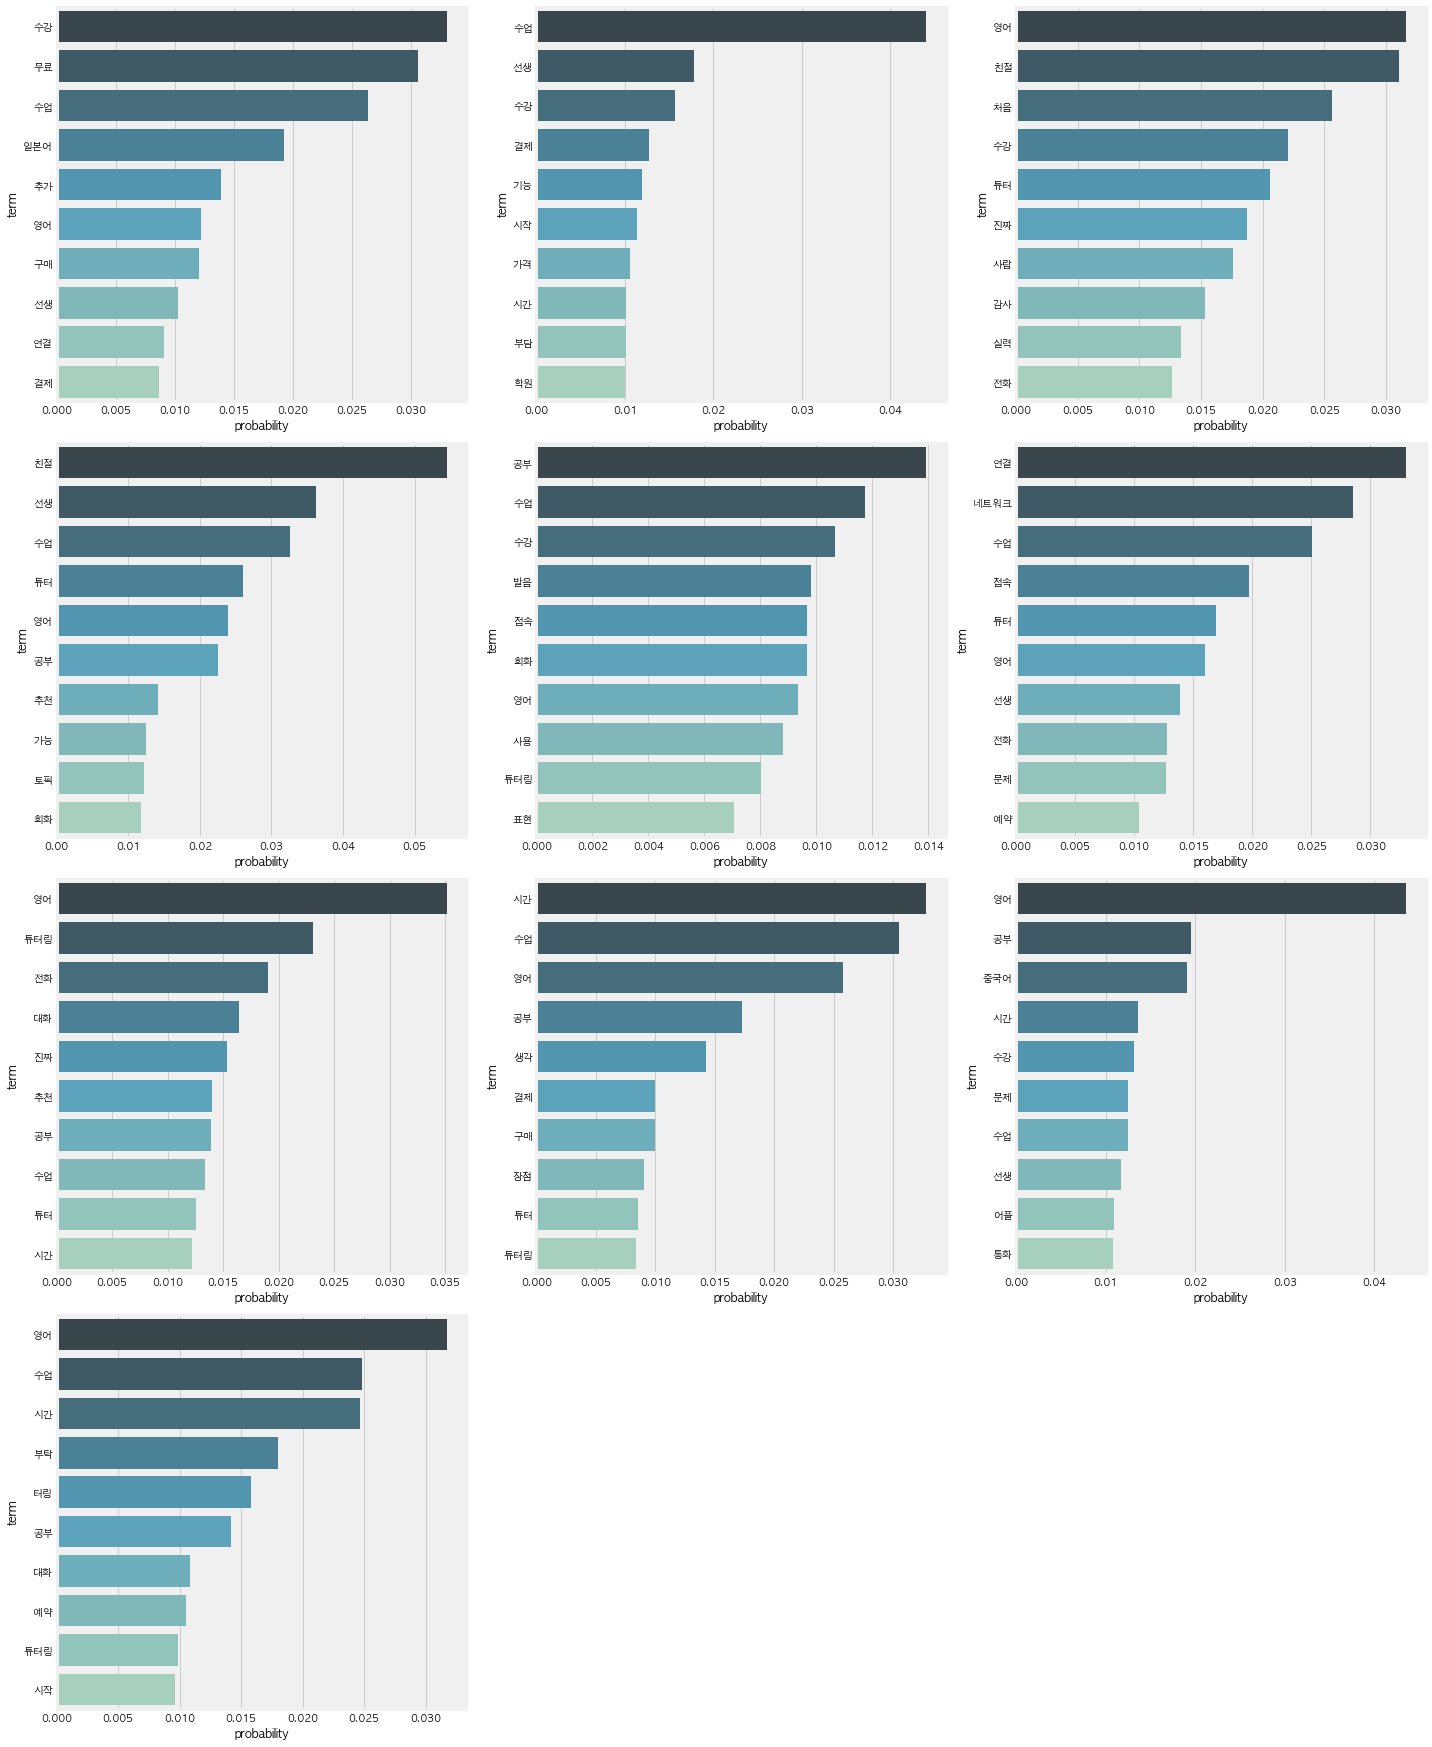

In [52]:
# run Topic modeling
make_lda_model_with_news(all_rating_extracted_user_comment_noun_list, 10, 'all_rating')

### 별점 2점 이하일 경우에 대한 분석

In [53]:
# get user_comment_noun_list of low rating reviews

low_rating_user_comment_list = arranged_user_review_df[arranged_user_review_df['user_app_rating'] <= 2]['user_comment'].tolist()
low_rating_extracted_user_comment_noun_list = execute_khaiii(low_rating_user_comment_list)

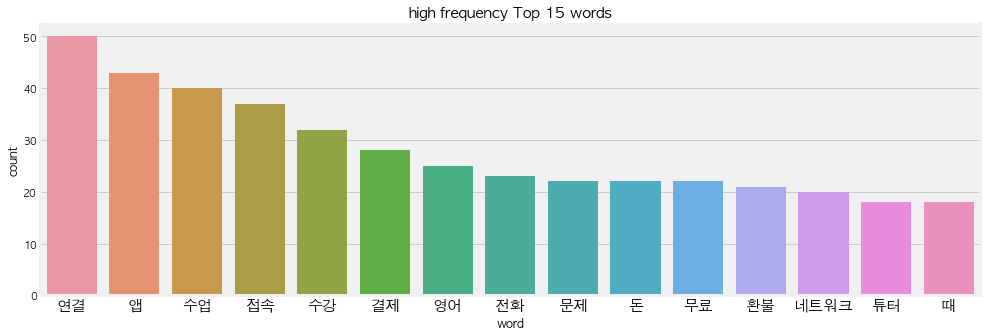

In [54]:
low_rating_word_count_df_new = get_dataframe_from_noun_list(low_rating_extracted_user_comment_noun_list)
draw_graph(low_rating_word_count_df_new)

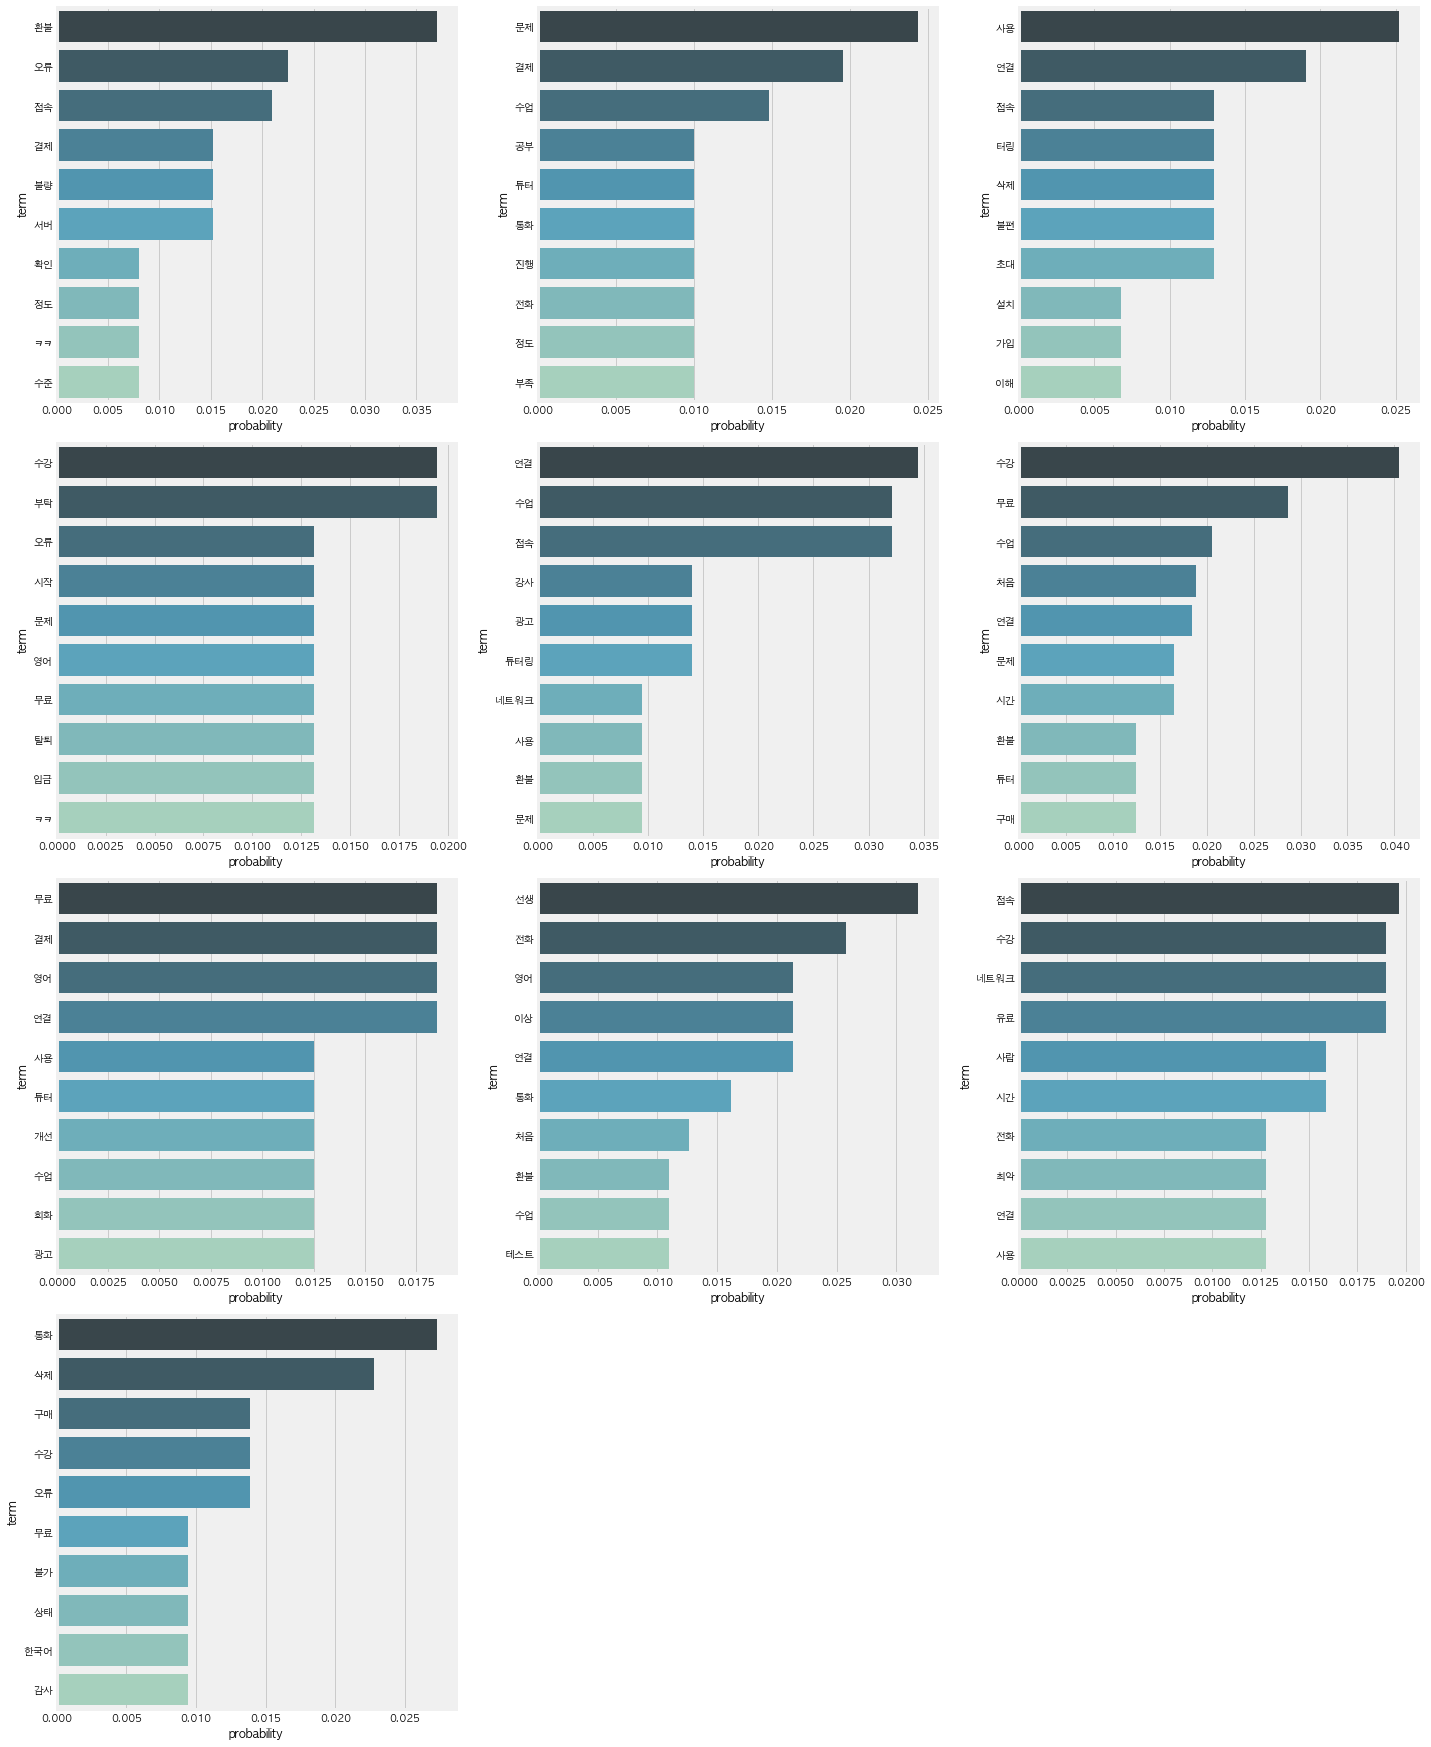

In [55]:
# run Topic modeling

make_lda_model_with_news(low_rating_extracted_user_comment_noun_list, 10, 'low_rating')

In [56]:
# import operator
# sorted_x = sorted(kewword_dict.items(), key=operator.itemgetter(1), reverse=True)
# sorted_x